In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

<font size="3" color='blue'>    <b>Offset correction for EMG -> +0.28 on Biceps</b>

In [2]:
pID = '3.3'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 0.1s
data_eeg_name_01 = '\data_s3_rp-win_-0.1-0_srate-250_modality-eeg.csv'
data_emg_name_01 = '\data_s3_rp-win_-0.1-0_srate-250_modality-emg.csv'
data_eye_name_01 = '\data_s3_rp-win_-0.1-0_srate-250_modality-eye.csv'

data_eeg_01 = pd.read_csv(path+pID+data_eeg_name_01)

# 1s
data_eeg_name_1 = '\data_s3_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s3_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s3_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

In [3]:
data_eeg

,sample,epoch_ix,rp_class,Fp1,P5,PO7,P3,PO4,Oz,POz,...,O1,PO8,PO3,CP2,C2,P1,AF4,CP5,F2,CP1
0,-0.996,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.992,1,1,-3.954044,2.345953,-10.554047,1.145952,6.345953,2.645950,1.145950,...,-22.554045,11.945953,7.345951,0.845955,1.045952,1.445953,6.045956,-8.054047,1.845953,-1.554047
2,-0.988,1,1,-1.889671,13.810328,-18.489670,5.710327,10.410331,16.810328,7.510326,...,-3.489670,21.010330,11.410328,0.610329,-1.389671,1.810330,1.310329,-5.989670,0.310330,-0.989670
3,-0.984,1,1,0.585060,18.685061,-5.014942,8.685059,6.885062,7.385059,7.385059,...,2.085061,14.785062,10.285061,-1.914940,-5.714940,2.785062,-4.014935,0.385059,-3.814938,-0.814939
4,-0.980,1,1,-2.143139,5.556860,13.856857,4.556858,21.656860,26.056857,16.056854,...,15.156860,40.856861,8.656857,-2.543140,-9.243141,2.156859,-4.343143,-2.043142,-9.343141,-3.343142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71495,-0.016,286,2,-1.015535,2.484467,-10.815534,3.384462,13.784467,14.084465,5.784465,...,12.184466,12.684464,-13.415535,-4.815535,-9.615533,0.084466,-0.515533,12.984467,-7.615535,-2.115536
71496,-0.012,286,2,8.558407,12.858406,-7.641591,4.758408,6.558406,1.558407,1.658411,...,6.958410,1.058407,-14.141592,-6.841589,-10.541591,-0.541592,4.358406,7.758408,-5.941592,-3.341595
71497,-0.008,286,2,4.445038,7.345036,-6.954964,1.245033,15.445037,4.045033,5.345035,...,3.545036,21.645027,-13.554965,-5.754963,-11.554965,-2.954964,2.045029,0.245037,-5.654965,-6.754967
71498,-0.004,286,2,2.253723,8.953720,-5.146277,5.153721,9.753722,7.353722,5.053723,...,6.453721,1.853722,-5.446278,-4.046276,-7.846277,-0.546277,2.053719,4.453724,-3.546277,-3.746277


<font size="4">    <b>Epoch representation, Highlight when the 2 classes are significatively differents ??</b>

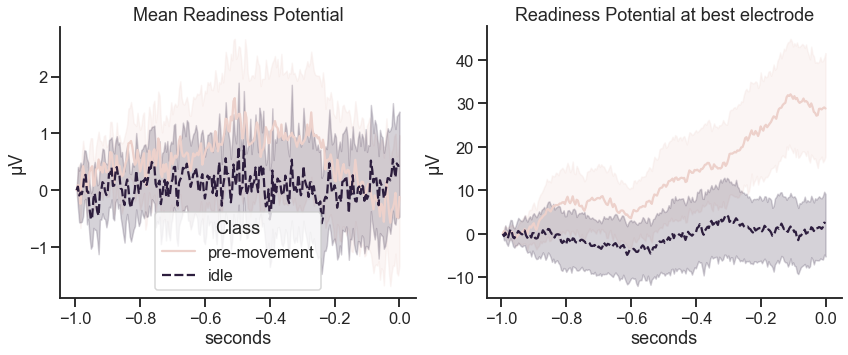

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrodes = data_eeg.iloc[:,3:].mean(axis=1)
electrode = 'Fp1'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=data_eeg)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data_eeg, legend=False)
g2.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at best electrode')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

<font size="4">    <b>Feature extraction</b>
    
EEG: We want to extract 1 feature (mean) at each window having a size of 25 samples, so 10 times per epoch or per second.
    
    -> 10 features per epoch per channel.

EMG: We want to extract X features (5 ? See if selection) at each window having a size of 100 samples, so 10 times per epoch or per seconds.
    
    ->10 features per epoch per channel (better do features on win_size 25 ? so 40 features per epoch per channel).

In [6]:
#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [9]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)


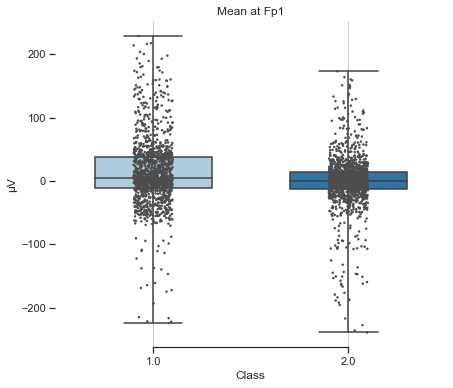

In [10]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = 'rp_class'
val_var = 'Fp1'

F1 = sns.boxplot(x=group_var, y=val_var, data=win_eeg_mean,
              whis=[0, 100], width=.6, palette='Paired')
F1.set(title='Mean at '+ val_var)

    # Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=win_eeg_mean,
              size=2.5, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='\u03bcV', xlabel='Class')
sns.despine(trim=True, left=True)

<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [11]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.6610837438423646
0.0814965787549316


<font size="3">    <b>Classification metrics - EEG</b>

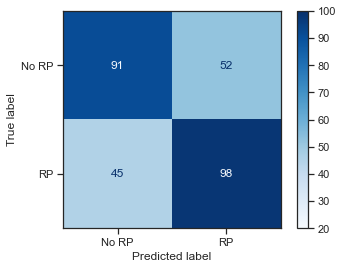

              precision    recall  f1-score   support

       No RP       0.67      0.64      0.65       143
          RP       0.65      0.69      0.67       143

    accuracy                           0.66       286
   macro avg       0.66      0.66      0.66       286
weighted avg       0.66      0.66      0.66       286



In [12]:
cm_eeg = confusion_matrix(y_true=yeeg, y_pred=pred_y_eeg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=yeeg, 
                                y_pred=pred_y_eeg, 
                                target_names=["No RP", "RP"]))

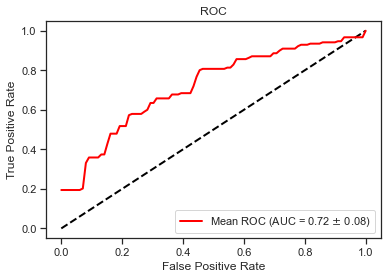

In [13]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xeeg,yeeg):
    prediction = clf_eeg.fit(Xeeg[train],yeeg[train]).predict_proba(Xeeg[test])
    fpr, tpr, t = roc_curve(yeeg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EMG</b>

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3" color='red'>    <b>Load the data and keep 20 best EEG</b>

In [15]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3.3/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3.3/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3.3/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3.3/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None) # , dtype='float16'
velocity = pd.read_csv(pathm, header=None) # , dtype='float16'

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

<font size="3" color='red'>    <b>Extract the time frame of interest around the movement onset</b>

In [16]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='red'>    <b>Baseline correction: I think this messes up the final result</b>

In [17]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3" color='red'>    <b>EEG Feature extraction</b>

In [18]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+10*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

In [19]:
feat.shape

(179, 200, 2751)

<font size="3" color='red'>    <b>Probability extraction</b>

In [20]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>Final DataFrame and representation</b>

In [21]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity * 1000
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.011970,0.175701
1,-1.999,0.010611,0.162575
2,-1.998,0.009149,0.220119
3,-1.997,0.007697,0.313083
4,-1.996,0.006294,0.284066
...,...,...,...
492424,0.746,0.952502,0.670550
492425,0.747,0.969210,0.665285
492426,0.748,0.985135,0.677555
492427,0.749,1.000606,0.686718


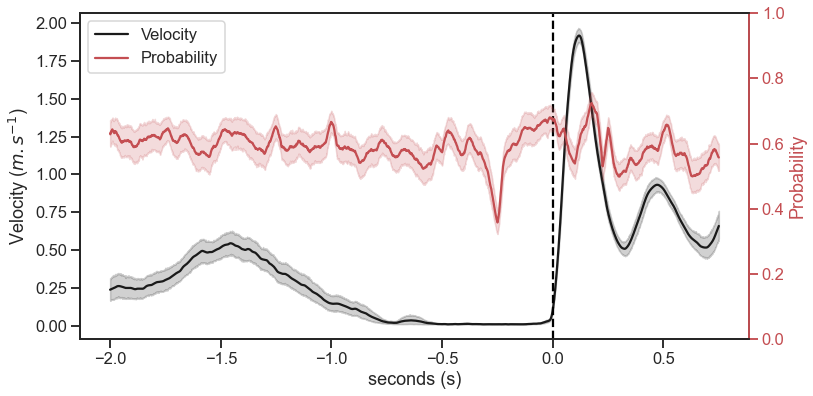

In [29]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))
# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

In [28]:
final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())]

-0.25